In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


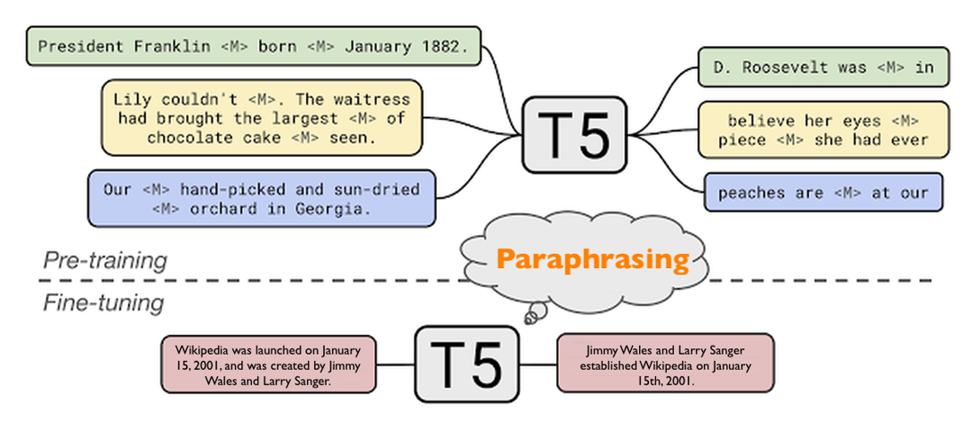

In [ ]:
from PIL import Image
img = Image.open('/content/drive/MyDrive/news_summarization/dataset/T5.png')

resized_im = img.resize((round(img.size[0]*0.9), round(img.size[1]*0.9)))
resized_im


# **Install libraries**

In [ ]:
!pip install -q torch
!pip install -q transformers
# !pip install -q pytorch_lightning
!pip install -q sentencepiece
!pip install -q pytorch_lightning==0.7.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 95.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.4 MB/s eta 0:00:00


In [ ]:
# Check we have a GPU and check the memory size of the GUP
!nvidia-smi

Sun Apr 16 19:59:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Import packages**

In [ ]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# **Set a seed**

In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

set_seed(42)



```
# This is formatted as code
```

# **T5FineTuner**

In [ ]:
class T5FineTuner(pl.LightningModule):
    def __init__(self, hparams):
        super(T5FineTuner, self).__init__()
        self.hparams = hparams
        # for key in hparams.keys():
        #   self.hparams[key]=hparams[key]

        self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
        self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)

    def is_logger(self):
        return True #self.trainer.proc_rank <= 0

    def forward(
            self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
    ):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=lm_labels,
        )

    def _step(self, batch):
        lm_labels = batch["target_ids"]
        lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            lm_labels=lm_labels,
            decoder_attention_mask=batch['target_mask']
        )

        loss = outputs[0]

        return loss

    def training_step(self, batch, batch_idx):
        loss = self._step(batch)

        tensorboard_logs = {"train_loss": loss}
        return {"loss": loss, "log": tensorboard_logs}

    def training_epoch_end(self, outputs):
        avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
        tensorboard_logs = {"avg_train_loss": avg_train_loss}
        return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        loss = self._step(batch)
        return {"val_loss": loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        tensorboard_logs = {"val_loss": avg_loss}
        return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def configure_optimizers(self):
        "Prepare optimizer and schedule (linear warmup and decay)"

        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        self.opt = optimizer
        return [optimizer]

    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None, on_tpu=False, using_native_amp=False, using_lbfgs=False):
        if self.trainer.use_tpu:
            xm.optimizer_step(optimizer)
        else:
            optimizer.step()
        optimizer.zero_grad()
        self.lr_scheduler.step()

    def get_tqdm_dict(self):
        tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

        return tqdm_dict

    def train_dataloader(self):
        train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", args=self.hparams)
        dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True,
                                num_workers=4)
        t_total = (
                (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
                // self.hparams.gradient_accumulation_steps
                * float(self.hparams.num_train_epochs)
        )
        scheduler = get_linear_schedule_with_warmup(
            self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
        )
        self.lr_scheduler = scheduler
        return dataloader

    def val_dataloader(self):
        val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="valid", args=self.hparams)
        return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      # Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      # Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))

# **Load datasets**

In [ ]:
data_train = pd.read_excel("/content/drive/MyDrive/news_summarization/dataset/train.xlsx")
data_train.head()

,headlines,text
0,The concept of 'Fashion 2' is ready: Madhur Bh...,Madhur Bhandarkar has revealed that the concep...
1,SC rejects plea against bail to Ryan school tr...,The Supreme Court on Monday dismissed a petiti...
2,Punjab CM gives Canada PM Justin Trudeau list ...,Punjab CM Amarinder Singh on Wednesday gave Ca...
3,Indian Air Force celebrates its 85th anniversary,The Indian Air Force (IAF) on Sunday celebrate...
4,Apple services make more money than sale of 'o...,Technology giant Apple has announced that the ...


In [ ]:
data_train = data_train.dropna()

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  3600 non-null   object
 1   text       3600 non-null   object
dtypes: object(2)
memory usage: 56.4+ KB


In [ ]:
data_train.shape

(3600, 2)

In [ ]:
data_valid = pd.read_excel("/content/drive/MyDrive/news_summarization/dataset/valid.xlsx")

In [ ]:
print('Training data: ', data_train.shape)
print('Validation data: ', data_valid.shape)

Training data:  (3600, 2)
Validation data:  (400, 2)


# **Set arguments**

In [ ]:
args_dict = dict(
    data_dir="", # path for data files
    output_dir="", # path to save the checkpoints
    model_name_or_path='t5-small',
    tokenizer_name_or_path='t5-small',
    max_seq_length=256,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=1,
    eval_batch_size=1,
    num_train_epochs=5,
    gradient_accumulation_steps=16,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)

train_path = "/content/drive/MyDrive/news_summarization/dataset/train.xlsx"
val_path = "/content/drive/MyDrive/news_summarization/dataset/valid.xlsx"

train = pd.read_excel(train_path).astype(str)
print(train.head())

tokenizer = T5Tokenizer.from_pretrained('t5-small')

                                           headlines  \
0  The concept of 'Fashion 2' is ready: Madhur Bh...   
1  SC rejects plea against bail to Ryan school tr...   
2  Punjab CM gives Canada PM Justin Trudeau list ...   
3   Indian Air Force celebrates its 85th anniversary   
4  Apple services make more money than sale of 'o...   

                                                text  
0  Madhur Bhandarkar has revealed that the concep...  
1  The Supreme Court on Monday dismissed a petiti...  
2  Punjab CM Amarinder Singh on Wednesday gave Ca...  
3  The Indian Air Force (IAF) on Sunday celebrate...  
4  Technology giant Apple has announced that the ...  


/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


# **SummarizeDataset()**

In [ ]:
class SummarizeDataset(Dataset):
    def __init__(self, tokenizer, data_dir, type_path, max_len=512):
        self.path = os.path.join(data_dir, type_path + '.xlsx')

        self.source_column = "text"
        self.target_column = "headlines"
        self.data = pd.read_excel(self.path).astype(str)

        self.max_len = max_len
        self.tokenizer = tokenizer
        self.inputs = []
        self.targets = []

        self._build()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        source_ids = self.inputs[index]["input_ids"].squeeze()
        target_ids = self.targets[index]["input_ids"].squeeze()

        src_mask = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
        target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}

    def _build(self):
        for idx in range(len(self.data)):
            input_, target = self.data.loc[idx, self.source_column], self.data.loc[idx, self.target_column]

            input_ = "summarize: "+ input_ + ' </s>'
            target = target + " </s>"

            # tokenize inputs
            tokenized_inputs = self.tokenizer.batch_encode_plus(
                [input_], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt", truncation='longest_first'
            )
            # tokenize targets
            tokenized_targets = self.tokenizer.batch_encode_plus(
                [target], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt", truncation='longest_first'
            )

            self.inputs.append(tokenized_inputs)
            self.targets.append(tokenized_targets)

# **Start training**

In [ ]:
dataset = SummarizeDataset(tokenizer, '/content/drive/MyDrive/news_summarization/dataset/', 'train', 256)
print("Train dataset: ",len(dataset))

data = dataset[61]
print(tokenizer.decode(data['source_ids']))
print(tokenizer.decode(data['target_ids']))

if not os.path.exists('t5_paraphrase'):
    os.makedirs('t5_paraphrase')

args_dict.update({'data_dir': '/content/drive/MyDrive/news_summarization/dataset/', 'output_dir': 't5_paraphrase', 'num_train_epochs':4,'max_seq_length':256})
args = argparse.Namespace(**args_dict)
print(args_dict)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=args.output_dir, prefix='checkpoint', monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
 #   early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)

def get_dataset(tokenizer, type_path, args):
  return SummarizeDataset(tokenizer=tokenizer, data_dir=args.data_dir, type_path=type_path,  max_len=args.max_seq_length)

print ("Initialize model")
model = T5FineTuner(args)

trainer = pl.Trainer(**train_params)

print (" Training model")
trainer.fit(model)

print ("training finished")

print ("Saving model")
model.model.save_pretrained('t5_paraphrase')

print ("Model saved")

# !cp "/content/t5_paraphrase/" -a "/content/drive/My Drive/"
# !cp "/content/lightning_logs/" -a "/content/drive/My Drive/"
# print ("Copied the final folder to Google Drive")

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:226: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


Train dataset:  3600
summarize: Doctors from Maharashtra's Sion Hospital have recently entered the Guinness Book of World Records by removing the world's heaviest kidney tumour weighing 5.5 kg. The tumour, which was 50 times heavier than a healthy kidney, was removed from the kidney of a 28-year-old woman during an eight-hour surgery in November 2016.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


 Training model


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:226: UserWarning: This sequence already has </s>. In future versions this behavior m

Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:226: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoade

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

training finished
Saving model
Model saved


# **Start testing**

In [ ]:
!cp "/content/t5_paraphrase/" -a "/content/drive/MyDrive/news_summarization/saved_model/"
# !cp "/content/lightning_logs/" -a "/content/drive/MyDrive/news_summarization/saved_model/"
print ("Copied the final folder to Google Drive")

Copied the final folder to Google Drive


In [ ]:
import torch
from transformers import T5ForConditionalGeneration,T5Tokenizer

def set_seed(seed):
  torch.manual_seed(seed)
#  if torch.cuda.is_available():
#   torch.cuda.manual_seed_all(seed)

set_seed(42)

best_model_path = "/content/drive/MyDrive/news_summarization/saved_model/"
model = T5ForConditionalGeneration.from_pretrained(best_model_path)
tokenizer = T5Tokenizer.from_pretrained('t5-small')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print ("device ",device)
model = model.to(device)

device  cuda


/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
import pandas as pd
from tqdm import tqdm

test_df = pd.read_excel('/content/drive/MyDrive/news_summarization/dataset/valid.xlsx')

with open('/content/drive/MyDrive/news_summarization/dataset/test_summarize.txt', 'w') as fp:
  for news in tqdm(test_df['text']):
    text =  "summarize: " + news + " </s>"

    max_len = 256

    encoding = tokenizer.encode_plus(text,pad_to_max_length=True, return_tensors="pt")
    input_ids, attention_masks = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)

    # set top_k = 50 and set top_p = 0.95 and num_return_sequences = 3
    beam_outputs = model.generate(
        input_ids=input_ids, attention_mask=attention_masks,
        do_sample=True,
        max_length=256,
        top_k=120,
        top_p=0.98,
        early_stopping=True,
        num_return_sequences=5
    )

    fp.write("Original news: \n")
    fp.write(news)
    fp.write("\n\n")
    fp.write("Summarized headline: \n")
    final_outputs =[]
    for beam_output in beam_outputs:
        sent = tokenizer.decode(beam_output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
        # print(sent)
        if sent.lower() != news.lower() and sent not in final_outputs:
            final_outputs.append(sent)

    for i, final_output in enumerate(final_outputs):
        fp.write("{}: {}".format(i, final_output))
        fp.write('\n')
    fp.write('\n\n***************************************************************\n\n')

  0%|          | 0/400 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:226: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
100%|██████████| 400/400 [02:04<00:00,  3.21it/s]


# Inference

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip3 install -q transformers
!pip3 install -q sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.9 MB/s eta 0:00:00


In [4]:
import torch
import pandas as pd
from transformers import T5ForConditionalGeneration,T5Tokenizer, AutoTokenizer

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def set_seed(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(42)

best_model_path = "/content/drive/MyDrive/news_summarization/saved_model/"
model = T5ForConditionalGeneration.from_pretrained(best_model_path).to(device)
tokenizer = T5Tokenizer.from_pretrained('t5-small')

In [7]:
def get_summary(sentence):
  text =  "summarize: " + sentence + " </s>"

  max_len = 256

  encoding = tokenizer.encode_plus(text,pad_to_max_length=True, return_tensors="pt")
  input_ids, attention_masks = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)

  # set top_k = 50 and set top_p = 0.95 and num_return_sequences = 3
  beam_outputs = model.generate(
      input_ids=input_ids, attention_mask=attention_masks,
      num_beams=5,
      temperature=1.5,
      num_beam_groups=5,
      diversity_penalty=2.0,
      do_sample=False,
      max_length=256,
      top_k=120,
      top_p=0.98,
      no_repeat_ngram_size=2,
      length_penalty=2.0,
      early_stopping=True,
      num_return_sequences=5
  )

  summaries = []

  for beam_output in beam_outputs:

      sent = tokenizer.decode(beam_output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
      # print(sent)
      if sent.lower() != sentence.lower() and sent not in summaries:
          summaries.append(sent)
  
  response = ''

  for i, smry in enumerate(summaries):
    response += str(i+1) + '. ' + smry + '\n'
  return response

In [8]:
news = "Incumbent Himachal Pradesh CM Virbhadra Singh has submitted his resignation to Governor Acharya Devvrat after the Congress' defeat in the Assembly elections. The Congress managed to win 21 seats against the 44 secured by BJP in the 68-member Assembly. The Governor accepted Singh's resignation and asked him to continue in office till the new government is formed."

print(get_summary(news))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:226: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


1. Himachal CM Virbhadra submits resignation to Governor
2. CM Virbhadra submits resignation to Governor Acharya
3. Govt submits resignation to Acharya after Congress defeat
4. Govt submits resignation to Acharya after Congress defeat in Assembly elections
5. Govt submits resignation to Acharya after Congress defeat in Assembly



# Gradio UI

In [9]:
!pip install -q gradio

In [10]:
import gradio as gr

iface = gr.Interface(
    fn=get_summary,
    inputs=gr.inputs.Textbox(lines=5, label="Input Text"),
    outputs=gr.outputs.Textbox(label="Summary"),
    title="Text Summarization",
    description="Summarize news into headlines."
)

if __name__ == "__main__":
    iface.launch(share=True)

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:22: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://3dacd4f41524341322.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
